In [1]:
import os
import cv2
from tqdm import tqdm
from pathlib import Path
from collections import defaultdict

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset
from torch.utils.data import RandomSampler

import torchvision.transforms as T
import torchvision.transforms.functional as VF
import torchvision.models as models

from matplotlib import pyplot as plt
import seaborn as sb




/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
CONFIG = dict(
    img_size=(128, 128),
    batch_size=32,
    epochs=10,  # Define the number of training epochs here
    learning_rate=1e-3,
    scheduler="steplr",
    step_size=5,
    gamma=0.75,
    dataloader_workers=2,
    train_log_step=500,
    valid_log_step=10,
    test_log_step=10,
    class_size = 100,
    infra="kaggle",
    device="cuda" if torch.cuda.is_available() else "cpu",
    architecture="resnet152",
)

vgg16 = dict(
    img_size=(128, 128),
    batch_size=32,
    learning_rate=1e-3,
    scheduler="steplr",
    step_size=5,
    gamma=0.75,
    dataloader_workers=2,
    train_log_step=500,
    valid_log_step=10,
    test_log_step=10,
    infra="kaggle",
    device="cuda" if torch.cuda.is_available() else "cpu",
    dataset="100-bird-species",
    architecture="vgg16",
    num_classes=100,
    class_size=100,
    pretrained=True,
    fine_tune=False,
    dropout=0.5,
    weight_decay=1e-4,
)


In [3]:
TRAIN_DIR = Path("../input/100-bird-species/train/")
VALID_DIR = Path("../input/100-bird-species/valid/")
TEST_DIR = Path("../input/100-bird-species/test/")

In [4]:
import torchvision.models as models

# Initialize ResNet-152 and VGG16 models
model_resnet152 = models.resnet152(pretrained=True)  # You can load a pre-trained model or initialize your own
model_vgg16 = models.vgg16(pretrained=True)  # You can load a pre-trained model or initialize your own


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.

In [5]:
import torch.optim as optim

# Initialize the optimizer
optimizer_resnet152 = optim.SGD(model_resnet152.parameters(), lr=0.001, momentum=0.9)
optimizer_vgg16 = optim.SGD(model_vgg16.parameters(), lr=0.001, momentum=0.9)



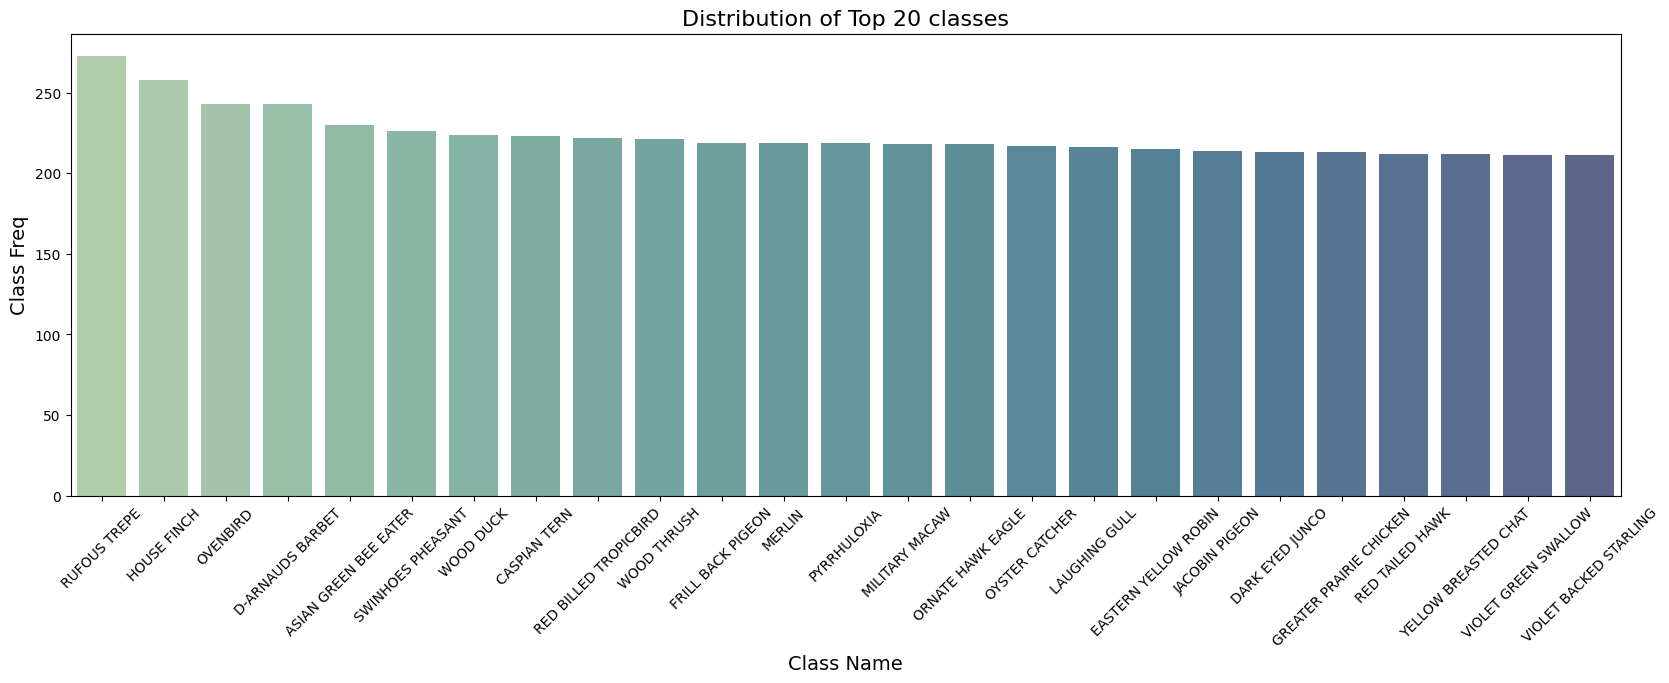

In [6]:
# Class Statistics and Distribution Plot
img_paths = list(TRAIN_DIR.glob(r'**/*.*')) + list(VALID_DIR.glob(r'**/*.*')) + list(TEST_DIR.glob(r'**/*.*'))

class_names_to_file = defaultdict(list)
for img_path in img_paths:
    name = str(img_path).split('/')[-2]
    class_names_to_file[name].append(img_path)

class_size = len(class_names_to_file)
class_to_label = {}
label_to_class = {}

label = 0
for name in class_names_to_file.keys():
    if name not in class_to_label:
        class_to_label[name] = label
        label_to_class[label] = name
        label += 1
class_freq = {name: len(files) for name, files in class_names_to_file.items()}
class_freq = pd.Series(data=class_freq).sort_values(ascending=False)
class_freq_subset = class_freq[:25]

plt.figure(figsize=(20, 6))
sb.barplot(
    x=class_freq_subset.index,
    y=class_freq_subset.values,
    alpha=0.8,
    palette="crest"
)
plt.title("Distribution of Top 20 classes", fontsize=16)
plt.xlabel('Class Name', fontsize=14)
plt.ylabel('Class Freq', fontsize=14)  # Changed from `plt.xlabel` to `plt.ylabel`
plt.xticks(rotation=45)
plt.show()


In [7]:
class BirdDataset(Dataset):
    
    def __init__(self, img_paths, class_to_label, transform=None):
        super().__init__()
        
        self.img_paths = img_paths
        self.class_to_label = class_to_label
        
        self.transform = transform
        self.len = len(img_paths)
    
    def __getitem__(self, index):
        img_path = str(self.img_paths[index])
        
        image = cv2.imread(img_path, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        
        if self.transform:
            image = self.transform(image)
        
        class_name = img_path.split('/')[-2]
        label = self.class_to_label[class_name]
        
        return image, label
    
    def __len__(self):
        return self.len

In [8]:
train_img_paths = [str(img_path) for img_path in TRAIN_DIR.glob(r'**/*.*')]
valid_img_paths = [str(img_path) for img_path in VALID_DIR.glob(r'**/*.*')]
test_img_paths = [str(img_path) for img_path in TEST_DIR.glob(r'**/*.*')]

In [9]:
img_transformation = T.Compose([
    T.ToTensor(),
    T.Resize(CONFIG["img_size"], antialias=True),
    T.RandomHorizontalFlip(p=0.5),
])

In [10]:
# Initialize the loss function
loss_function = nn.CrossEntropyLoss()  # You can change this based on your specific loss

In [11]:
# Define training, validation, and test datasets
train_dataset = BirdDataset(train_img_paths, class_to_label, img_transformation)
valid_dataset = BirdDataset(valid_img_paths, class_to_label, img_transformation)
test_dataset = BirdDataset(test_img_paths, class_to_label, img_transformation)


In [12]:
# Training, Validation, and Testing Data Loaders
train_data = DataLoader(
    dataset=train_dataset,
    batch_size=CONFIG["batch_size"],
    sampler=RandomSampler(train_dataset),
    num_workers=CONFIG["dataloader_workers"],
    pin_memory=True
)

valid_data = DataLoader(
    dataset=valid_dataset,
    batch_size=CONFIG["batch_size"],
    sampler=RandomSampler(valid_dataset),
    num_workers=CONFIG["dataloader_workers"],
    pin_memory=True
)

test_data = DataLoader(
    dataset=test_dataset,
    batch_size=CONFIG["batch_size"],
    sampler=RandomSampler(test_dataset),
    num_workers=CONFIG["dataloader_workers"],
    pin_memory=True
)

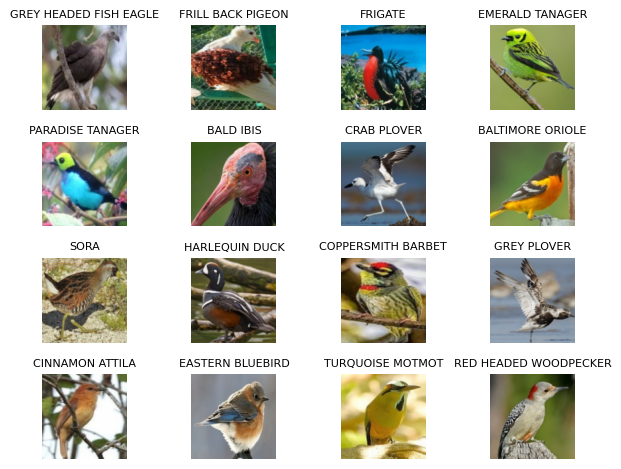

In [13]:
random_indicies = np.random.randint(0, len(train_dataset), 16)
fig, axes = plt.subplots(nrows=4, ncols=4)

for ax, rnd_idx in zip(axes.flat, random_indicies):
    img, label = train_dataset[rnd_idx]
    img = VF.to_pil_image(img)
    
    ax.imshow(np.asarray(img))
    ax.set_title(label_to_class[label], fontsize=8)
    ax.set_axis_off()
plt.tight_layout()
plt.show()

In [14]:
# Training loop
train_losses_resnet152 = []
train_losses_vgg16 = []
valid_losses_resnet152 = []
valid_losses_vgg16 = []
train_accuracies_resnet152 = []
train_accuracies_vgg16 = []
valid_accuracies_resnet152 = []
valid_accuracies_vgg16 = []

# Move the models to the selected device
model_resnet152.to(CONFIG["device"])
model_vgg16.to(CONFIG["device"])

for epoch in range(CONFIG["epochs"]):
    model_resnet152.train()
    model_vgg16.train()
    
    train_loss_resnet152 = 0.0
    train_loss_vgg16 = 0.0
    correct_resnet152 = 0
    correct_vgg16 = 0
    total = 0
    
    for batch_idx, (inputs, targets) in enumerate(train_data):
        inputs, targets = inputs.to(CONFIG["device"]), targets.to(CONFIG["device"])
        optimizer_resnet152.zero_grad()
        optimizer_vgg16.zero_grad()

        outputs_resnet152 = model_resnet152(inputs)
        loss_resnet152 = loss_function(outputs_resnet152, targets)

        outputs_vgg16 = model_vgg16(inputs)
        loss_vgg16 = loss_function(outputs_vgg16, targets)

        loss_resnet152.backward()
        optimizer_resnet152.step()

        loss_vgg16.backward()
        optimizer_vgg16.step()

        train_loss_resnet152 += loss_resnet152.item()
        train_loss_vgg16 += loss_vgg16.item()

        _, predicted_resnet152 = outputs_resnet152.max(1)
        _, predicted_vgg16 = outputs_vgg16.max(1)
        correct_resnet152 += predicted_resnet152.eq(targets).sum().item()
        correct_vgg16 += predicted_vgg16.eq(targets).sum().item()

        total += targets.size(0)

        if batch_idx % CONFIG["train_log_step"] == 0:
            print(f"Epoch [{epoch}/{CONFIG['epochs']}] Batch [{batch_idx}/{len(train_data)}]")
            print(f"Train Loss (ResNet-152): {train_loss_resnet152 / (batch_idx + 1)}")
            print(f"Train Loss (VGG16): {train_loss_vgg16 / (batch_idx + 1)}")

    train_losses_resnet152.append(train_loss_resnet152 / len(train_data))
    train_losses_vgg16.append(train_loss_vgg16 / len(train_data))
    train_accuracies_resnet152.append(100. * correct_resnet152 / total)
    train_accuracies_vgg16.append(100. * correct_vgg16 / total)

    model_resnet152.eval()
    model_vgg16.eval()

    valid_loss_resnet152 = 0.0
    valid_loss_vgg16 = 0.0
    correct_resnet152 = 0
    correct_vgg16 = 0

    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(valid_data):
            inputs, targets = inputs.to(CONFIG["device"]), targets.to(CONFIG["device"])
            outputs_resnet152 = model_resnet152(inputs)
            loss_resnet152 = loss_function(outputs_resnet152, targets)
            valid_loss_resnet152 += loss_resnet152.item()

            outputs_vgg16 = model_vgg16(inputs)
            loss_vgg16 = loss_function(outputs_vgg16, targets)
            valid_loss_vgg16 += loss_vgg16.item()

            _, predicted_resnet152 = outputs_resnet152.max(1)
            _, predicted_vgg16 = outputs_vgg16.max(1)
            correct_resnet152 += predicted_resnet152.eq(targets).sum().item()
            correct_vgg16 += predicted_vgg16.eq(targets).sum().item()

    valid_losses_resnet152.append(valid_loss_resnet152 / len(valid_data))
    valid_losses_vgg16.append(valid_loss_vgg16 / len(valid_data))
    valid_accuracies_resnet152.append(100. * correct_resnet152 / len(valid_data.dataset))
    valid_accuracies_vgg16.append(100. * correct_vgg16 / len(valid_data.dataset))

Epoch [0/10] Batch [0/2645]
Train Loss (ResNet-152): 11.708264350891113
Train Loss (VGG16): 20.122209548950195
Epoch [0/10] Batch [500/2645]
Train Loss (ResNet-152): 5.738012506576355
Train Loss (VGG16): 6.681730448366877
Epoch [0/10] Batch [1000/2645]
Train Loss (ResNet-152): 4.230944102698868
Train Loss (VGG16): 6.55587874592601
Epoch [0/10] Batch [1500/2645]
Train Loss (ResNet-152): 3.348139261500507
Train Loss (VGG16): 6.42818740111522
Epoch [0/10] Batch [2000/2645]
Train Loss (ResNet-152): 2.797504099546701
Train Loss (VGG16): 6.24538603453324
Epoch [0/10] Batch [2500/2645]
Train Loss (ResNet-152): 2.4198725321372954
Train Loss (VGG16): 6.018053512104222
Epoch [1/10] Batch [0/2645]
Train Loss (ResNet-152): 0.39102932810783386
Train Loss (VGG16): 4.537906646728516
Epoch [1/10] Batch [500/2645]
Train Loss (ResNet-152): 0.5524505460095739
Train Loss (VGG16): 4.177401505068628
Epoch [1/10] Batch [1000/2645]
Train Loss (ResNet-152): 0.5386601380118123
Train Loss (VGG16): 3.841858174060

In [20]:
final_train_accuracy_resnet152 = 100. * correct_resnet152 / total  # Final training accuracy
final_valid_accuracy_resnet152 = valid_accuracies_resnet152[-1]  # Final validation accuracy
final_train_accuracy_vgg16 = 100. * correct_vgg16 / total  # Final training accuracy
final_valid_accuracy_vgg16 = valid_accuracies_vgg16[-1]  # Final validation accuracy


print("Final Validation Accuracy (ResNet-152):", final_valid_accuracy_resnet152, "%")

print("Final Validation Accuracy (VGG16):", final_valid_accuracy_vgg16, "%")



Final Validation Accuracy (ResNet-152): 96.07619047619048 %
Final Validation Accuracy (VGG16): 93.94285714285714 %


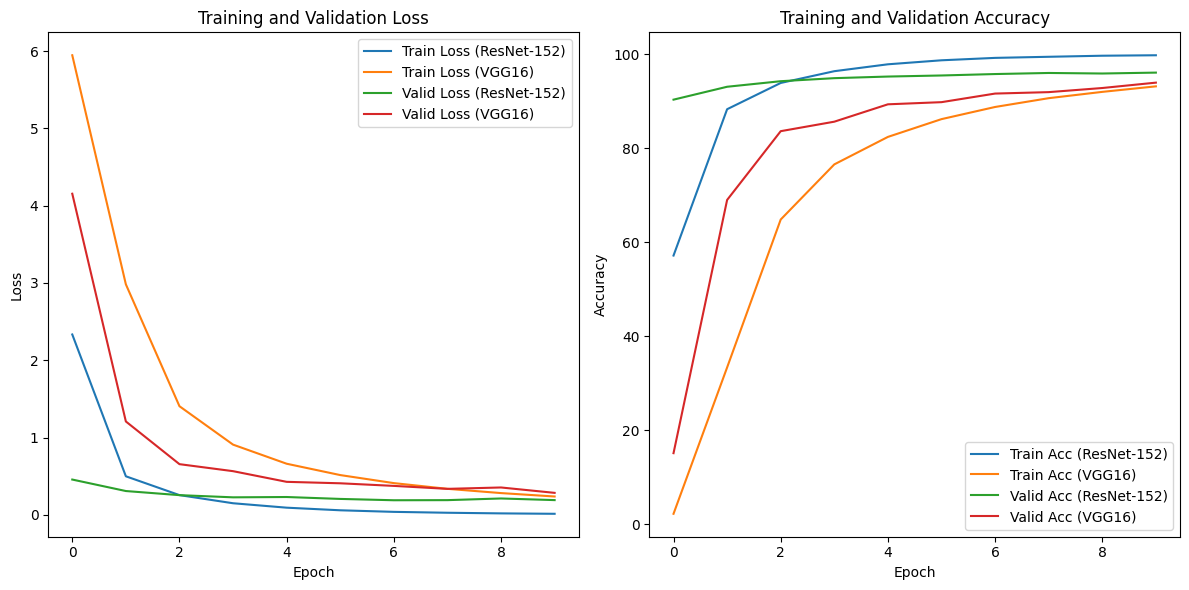

In [15]:
# Visualization of comparison
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses_resnet152, label="Train Loss (ResNet-152)")
plt.plot(train_losses_vgg16, label="Train Loss (VGG16)")
plt.plot(valid_losses_resnet152, label="Valid Loss (ResNet-152)")
plt.plot(valid_losses_vgg16, label="Valid Loss (VGG16)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies_resnet152, label="Train Acc (ResNet-152)")
plt.plot(train_accuracies_vgg16, label="Train Acc (VGG16)")
plt.plot(valid_accuracies_resnet152, label="Valid Acc (ResNet-152)")
plt.plot(valid_accuracies_vgg16, label="Valid Acc (VGG16)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()
